# Customer Churn Analysis And Prediction 

**Customer Churn**
It is when an existing customer, user, subscriber, or any kind of return client stops doing business or ends the relationship with a company.

**Types of Customer Churn**

- Contractual Churn : When a customer is under a contract for a service and decides to cancel the service e.g. Cable TV, SaaS.
- Voluntary Churn : When a user voluntarily cancels a service e.g. Cellular connection.
- Non-Contractual Churn : When a customer is not under a contract for a service and decides to cancel the service e.g. Consumer - Loyalty in retail stores.
- Involuntary Churn : When a churn occurs without any request of the customer e.g. Credit card expiration.

**Reasons for Voluntary Churn**
- Lack of usage
- Poor service
- Better price

**Data Attributes and Labels** 
<br>
The initial ingredient for building any predictive pipeline is data. For churn specifically, historical data is captured and stored in a data warehouse, depending on the application domain. The process of churn definition and establishing data hooks to capture relevant events is highly iterative. It is very important to keep this in mind as the initial churn definition, with its associated data hooks, may not be applicable or relevant anymore as a product or a service matures. That’s why it’s essential for data scientists to not only monitor the performance of the predictive pipeline over time but also to pay close attention to the alignment of churn definition with the product’s changes as they might affect who the churners are.

The specific attributes used in a churn model are highly domain dependent. However, broadly speaking, the most common attributes capture user behavior with regards to engagement level with a product or service. This can be thought of as the number of times that a user logs into her/his account in a week or the amount of time that a user spends on a portal. In short, frequency and intensity of usage/engagement are among the strongest signals to predict churn.

Find the data for analysis [here.](https://www.kaggle.com/barun2104/telecom-churn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the dataset
data = pd.read_csv('telecom_churn.csv')
data.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


**Data Description**

- Churn - 1 if customer cancelled service, 0 if not
- AccountWeeks - number of weeks customer has had active account
- ContractRenewal - 1 if customer recently renewed contract, 0 if not
- DataPlan - 1 if customer has data plan, 0 if not
- DataUsage - gigabytes of monthly data usage
- CustServCalls - number of calls into customer service
- DayMins - average daytime minutes per month
- DayCalls - average number of daytime calls
- MonthlyCharge - average monthly bill
- OverageFee - largest overage fee in last 12 months
- RoamMins - average number of roaming minutes

In [3]:
# General information about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [4]:
cols = [ 'ContractRenewal', 'DataPlan' ]

for col in cols:
    data[col] = data[col].astype('O')
    

## Exploratory Data Analysis

As always, the first thing we're going to do is explore our dataset. We have telecom customer data where each row represents a unique customer. In addition, we have a churn status, with values 1 if the customer has churned, and 0 if we have an active customer. However, we don't always have these labels, and sometimes we need to create them from scratch based on our prior business knowledge. 

In [5]:
data.describe()

,Churn,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


In [6]:
def plot_continuous(dataset, var_name):
    sns.displot(dataset[var_name])
    plt.axvline(dataset[var_name].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(dataset[var_name].median(), color='r', linewidth=1)
    plt.title(f'Distribution of variable "{var_name}"')

In [7]:
def plot_objects(dataset, var_name):
    sns.countplot(dataset[var_name])
    plt.title(f'Distribution of variable "{var_name}"')

The major problem with our data is that we have an unbalanced target. As we can see in the graph below, our dataset has more active customers than churned ones. Later we will see some techniques that will help us solve this problem.

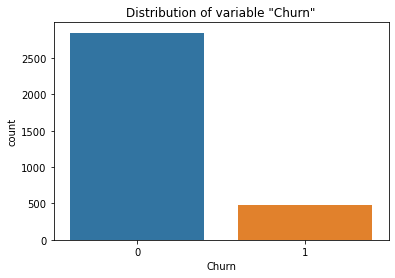

In [8]:
plot_objects(data, 'Churn')

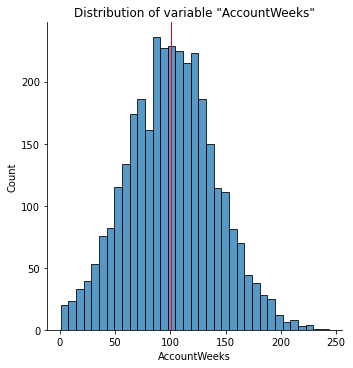

In [9]:
plot_continuous(data, 'AccountWeeks')

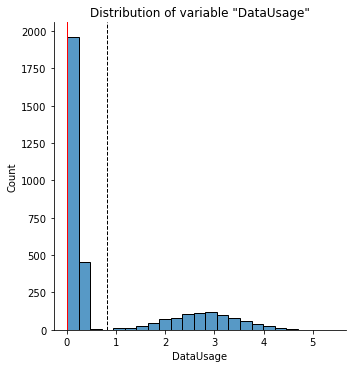

In [10]:
plot_continuous(data, 'DataUsage')

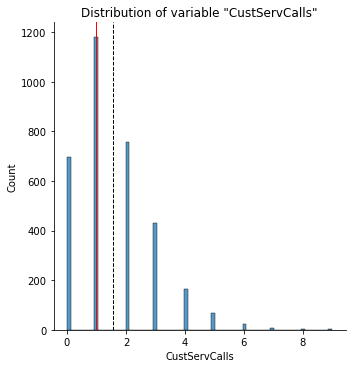

In [11]:
plot_continuous(data, 'CustServCalls')

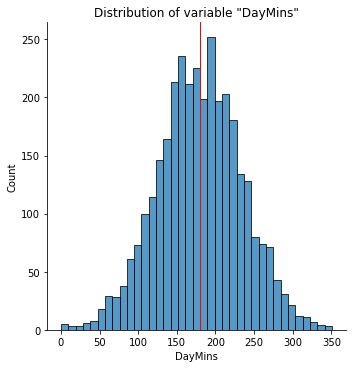

In [12]:
plot_continuous(data, 'DayMins')

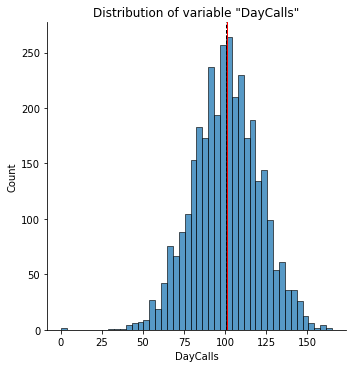

In [13]:
plot_continuous(data, 'DayCalls')

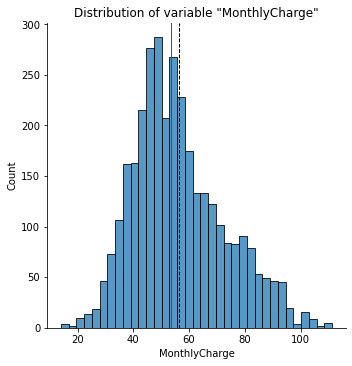

In [14]:
plot_continuous(data, 'MonthlyCharge')

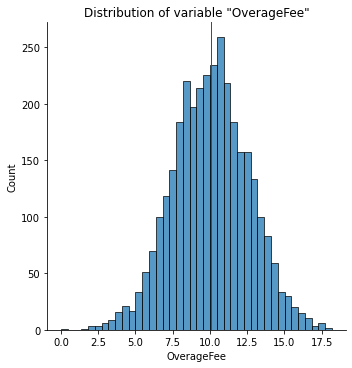

In [15]:
plot_continuous(data, 'OverageFee')

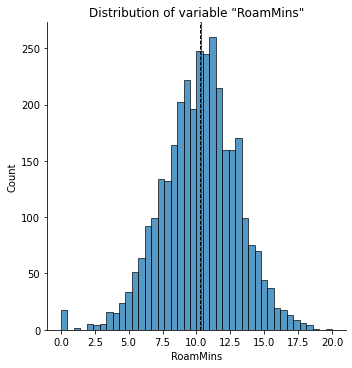

In [16]:
plot_continuous(data, 'RoamMins')

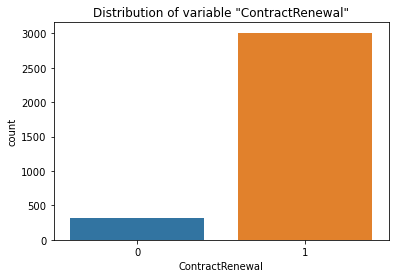

In [17]:
plot_objects(data, 'ContractRenewal')

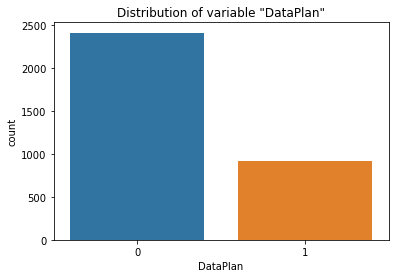

In [18]:
plot_objects(data, 'DataPlan')

## Find relations between variables

After exploring our variables separately, it is now turn to find the relationship between two or more variables. And remember that churn is our target variable and we need to first find some issues that may cause it.

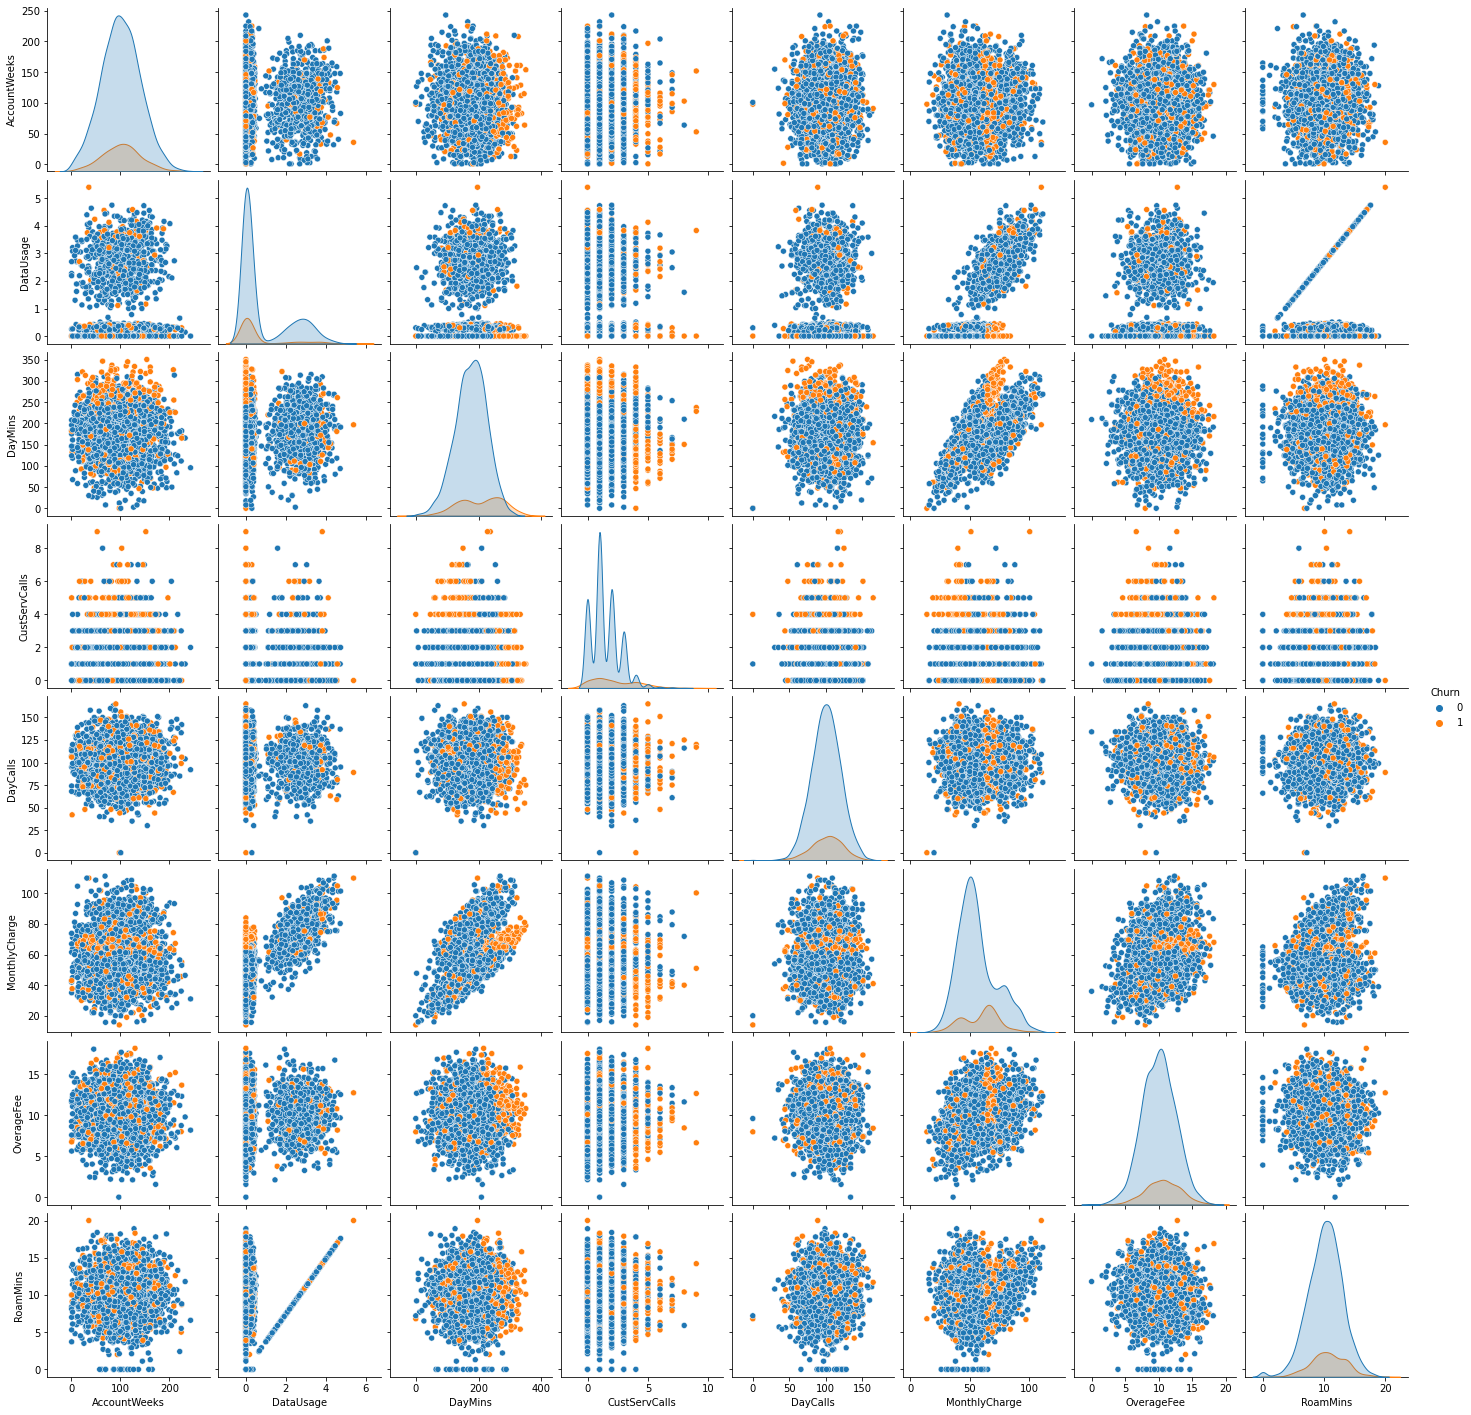

In [19]:
cols = ['AccountWeeks', 'DataUsage', 'DayMins','CustServCalls', 'DayCalls','MonthlyCharge', 'OverageFee', 'RoamMins' ]
sns.pairplot(data, vars = cols, hue = 'Churn')

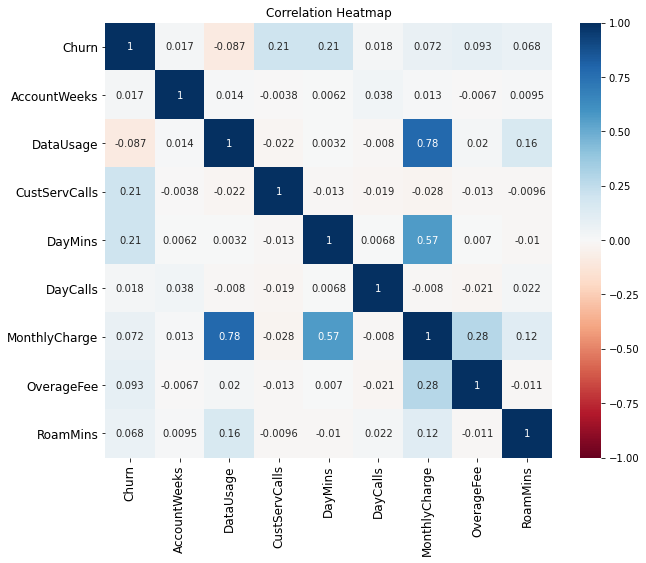

In [20]:
plt.figure(figsize = (10, 8))
s = sns.heatmap(data.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)

s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

Now let's dive into those two graphs above. We see that there is no obvious relationship between churn and other variables. However, there are other interesting discoveries worth discussing. For example, Monthly Charge and Data Usage are highly correlated, as are Monthly Charge and Daily Calls. 

Next we will look at the interaction of categorical variables with our target variable. The following heatmap shows that customers who have a data plan are less likely to leave. In the next heatmap, it's clear that customers who haven't renewed their contracts are more likely to churn.

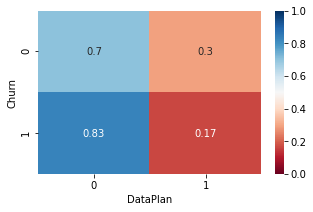

In [21]:
cross = pd.crosstab(data['Churn'], data['DataPlan']).apply(lambda r: r/r.sum(), axis=1)

plt.figure(figsize = (5, 3))
s = sns.heatmap(cross,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

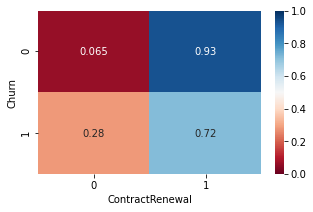

In [22]:
cross = pd.crosstab(data['Churn'], data['ContractRenewal']).apply(lambda r: r/r.sum(), axis=1)

plt.figure(figsize = (5, 3))
s = sns.heatmap(cross,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

Surprisingly, there isn't much of a relationship between churn and customer service calls. 

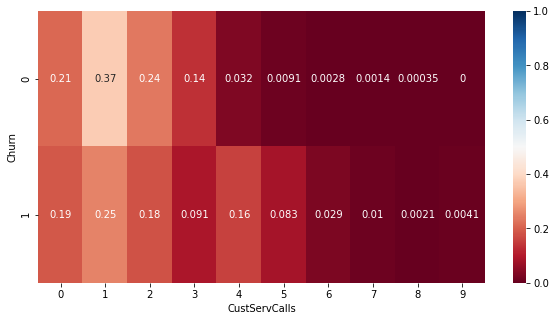

In [23]:
cross = pd.crosstab(data['Churn'], data['CustServCalls']).apply(lambda r: r/r.sum(), axis=1)

plt.figure(figsize = (10, 5))
s = sns.heatmap(cross,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

## Data Preprocessing and Modeling

In [24]:
data.Churn.value_counts()

0    2850
1     483
Name: Churn, dtype: int64

As mentioned earlier, we have unbalanced data, which means that single-label observations dominate. Here we can see that only 17% of the data is marked as "churned". The modeling result may be either too good to be believed or we may get incorrectly generalized model. So what can be done? There are several techniques that we can try on and compare the results.

### Version 1: without balancing

Let's start from modeling the original dataset.  

In [25]:
target = data['Churn'].astype(int)
X = data.drop(columns='Churn')
X.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [26]:
X = pd.get_dummies(X, columns=['ContractRenewal', 'DataPlan'])
X.head()

,AccountWeeks,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,ContractRenewal_0,ContractRenewal_1,DataPlan_0,DataPlan_1
0,128,2.7,1,265.1,110,89.0,9.87,10.0,0,1,0,1
1,107,3.7,1,161.6,123,82.0,9.78,13.7,0,1,0,1
2,137,0.0,0,243.4,114,52.0,6.06,12.2,0,1,1,0
3,84,0.0,2,299.4,71,57.0,3.10,6.6,1,0,1,0
4,75,0.0,3,166.7,113,41.0,7.42,10.1,1,0,1,0


In [27]:
train_x,test_x,train_y,test_y = train_test_split(X,target,test_size=0.25,random_state=42)
print(f"Number of observations \n Train set: {len(train_x)}\n Test set: {len(test_x)}")

Number of observations 
 Train set: 2499
 Test set: 834


We are going to try 3 different models: Logistic Regression, k Nearest Neighbor, Random Forest classifier. We're not going to dive into hyperparameter tuning, instead we're just trying to experiment with our dataset.

In [28]:
Logistic = LogisticRegression(random_state=42)
Knn = KNeighborsClassifier(n_neighbors=5)
RFC = RandomForestClassifier(n_estimators=100, random_state=42) 

In [29]:
def results(cls_list):
    indx = [ 'Acc_train', 'Acc_test', 'Recall_test', 'Precision_test']
    
    results = pd.DataFrame(index=indx, columns=['Logistic', 'Knn', 'RFC'])
    
    for i, cls in enumerate(cls_list):
        cls.fit(train_x,train_y)
        test_y_new = cls.predict(test_x)    
        train_y_new = cls.predict(train_x)
        acc_train = accuracy_score(train_y,train_y_new)
        acc_test = accuracy_score(test_y,test_y_new)
        rec_test = recall_score(test_y,test_y_new)
        pr_test = precision_score(test_y,test_y_new)
        name = results.columns[i]
        results[name] = [acc_train, acc_test, rec_test, pr_test]
    return results  
    
        

In [30]:
classifiers = [ Logistic, Knn, RFC]
res = results(classifiers)


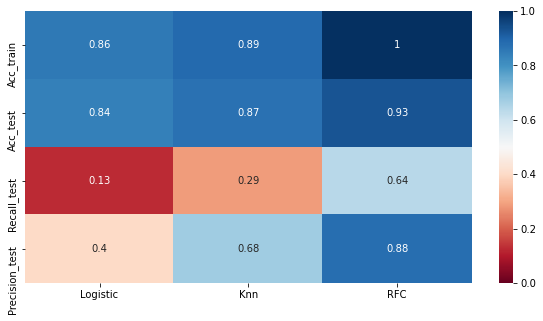

In [31]:
plt.figure(figsize = (10, 5))
s = sns.heatmap(res,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

Obviously we have an overfiting problem. Good results on train dataset, but recall and accuracy rates on test set show real problems with models. The small rate of recall is indicator of many false negatives, and precision rate shows that we have problem with false positives as well.

### Version 2: Down-sample Majority Class

The first way to solve the problem of unbalanced data is to reduce the data. This means that we will remove observations from the majority class. The main problem with this method is that we can lose too much data and end up with a bad model with poor generalization.Let's try the technique!

In [32]:
majority = data[data.Churn==0]
minority = data[data.Churn==1]
 

downsampled = resample(majority, 
                       replace=False,    
                       n_samples=483,     
                       random_state=42) 
 

downsampled = pd.concat([downsampled, minority])
 
downsampled['Churn'].value_counts()


1    483
0    483
Name: Churn, dtype: int64

In [33]:
target = downsampled['Churn'].astype(int)
X = downsampled.drop(columns='Churn')
X = pd.get_dummies(X, columns=['ContractRenewal', 'DataPlan'])

train_x,test_x,train_y,test_y = train_test_split(X,target,test_size=0.25,random_state=42)

print(f"Number of observations \n Train set: {len(train_x)}\n Test set: {len(test_x)}")

Number of observations 
 Train set: 724
 Test set: 242


In [34]:
res = results(classifiers)

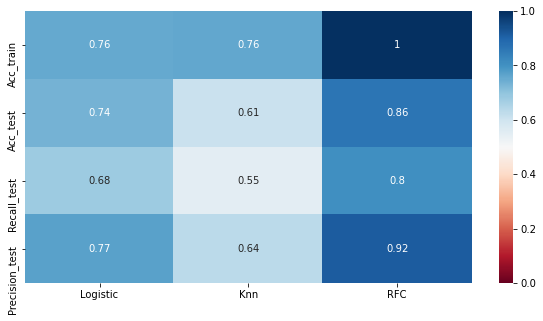

In [35]:
plt.figure(figsize = (10, 5))
s = sns.heatmap(res,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

As a result, we solved the problem of overfitting, because the accuracy of the test and training samples does not differ too much, moreover, the recall and precision are closer to each other. However, we now have a generalization problem! 


### Version 3: Up-sample Minority Class

We are moving to next technique: upsampling the minority class. This time we will resample the minority class so that it equals the majority. **Think about the problem this method might cause?**

In [36]:
upsampled = resample(minority, 
                     replace=True,     
                     n_samples=2850,    
                     random_state=42) 
 

upsampled = pd.concat([majority,upsampled])

upsampled['Churn'].value_counts()

1    2850
0    2850
Name: Churn, dtype: int64

In [37]:
target = upsampled['Churn'].astype(int)
X = upsampled.drop(columns='Churn')
X = pd.get_dummies(X, columns=['ContractRenewal', 'DataPlan'])

train_x,test_x,train_y,test_y = train_test_split(X,target,test_size=0.25,random_state=42)

print(f"Number of observations \n Train set: {len(train_x)}\n Test set: {len(test_x)}")

Number of observations 
 Train set: 4275
 Test set: 1425


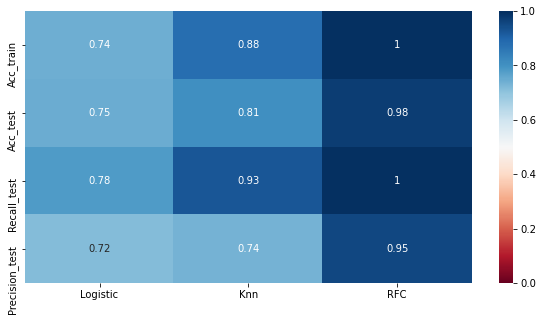

In [38]:
res = results(classifiers)

plt.figure(figsize = (10, 5))
s = sns.heatmap(res,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

Hmm, looks like we have a nearly perfect picture for a random forest classifier. But wait! What about data leakage? 

What actually happened, we made thousands of copies of the same observations, and then we split up into training and testing samples. As a result, we may have exactely same observations in training and testing sets, which means that we can get better results on the test dataset, but it's not convenient for real-world scenarios.

### Version 4: Upsample Minority Only On Train Set

Last but not least, in the last experiment, we will first split the data into train and test samples,then upsample data. Let's try it out!

In [39]:
target = data['Churn'].astype(int)
X = data.drop(columns='Churn')
X = pd.get_dummies(X, columns=['ContractRenewal', 'DataPlan'])

train_x,test_x,train_y,test_y = train_test_split(X,target,test_size=0.25,random_state=42)

print(f"Number of observations \n Train set: {len(train_x)}\n Test set: {len(test_x)}")

Number of observations 
 Train set: 2499
 Test set: 834


In [40]:
train = pd.concat([train_x, train_y],  axis = 1)
majority = train[train.Churn==0]
minority = train[train.Churn==1]
majority.shape

(2141, 13)

In [41]:
upsampled2 = resample(minority, 
                     replace=True,     
                     n_samples=2141,    
                     random_state=42) 
 

upsampled2 = pd.concat([majority,upsampled2])

upsampled2['Churn'].value_counts()

1    2141
0    2141
Name: Churn, dtype: int64

In [42]:
train_y = upsampled2['Churn'].astype(int)
train_x = upsampled2.drop(columns='Churn')

print(f"Number of observations \n Train set: {len(train_x)}\n Test set: {len(test_x)}")

Number of observations 
 Train set: 4282
 Test set: 834


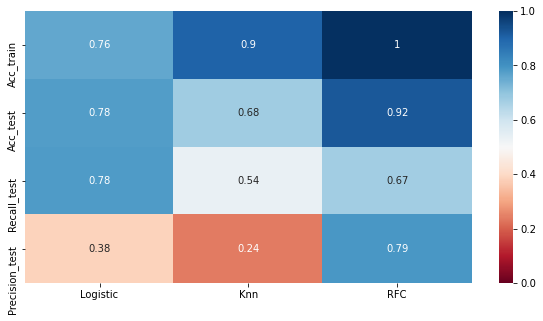

In [43]:
res = results(classifiers)

plt.figure(figsize = (10, 5))
s = sns.heatmap(res,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

This looks like what we want! Logistic regression has a high rate of recall, but lower precision, we cannot consider this as our final model. Knn has problems with both low recall and low precision. In the case of a Random Forest, we have lower recall than in Logistic regression, however we've got higher precision and overall accuracy than other models. So we will go with Random Forest classifier.

What's next? 
- Try another model and compare the results.
- Fine-tune the models we already have.
- Create meaningful new features.